In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import random
from sklearn import model_selection, preprocessing, svm, metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [144]:
class Open_csv:
    
    def __init__(self):
        pass
    
    def open(self,path_to_file):
        data = np.asarray(pd.read_csv(path_to_file, delimiter=",").values)
        return data

In [145]:
open_csv = Open_csv()
# open high low close

In [146]:
def f_1(vector):
    return (vector[2]-vector[3])/(vector[1]+vector[4]) # (high-low)/(open+close)

In [147]:
def compute_function_returns(function,data):
    returns = []
    for i in range(len(data)):
        returns.append(function(data[i]))
    return np.asarray(returns)

In [148]:
stock_list = ["AC.PA", "AI.PA", "AIR.PA", "ATO.PA", "BNP.PA", "EN.PA", "CAP.PA", "CA.PA", "ACA.PA", 
          "BN.PA", "ENGI.PA", "KER.PA", "OR.PA", "LHN.PA", "LR.PA", "MC.PA", "ML.PA", "ORA.PA",
          "UG.PA", "SGO.PA", "SAN.PA", "SU.PA", "GLE.PA", "SW.PA", "FP.PA", "FR.PA", "VIE.PA", "DG.PA", "VIV.PA"]

In [149]:
stock_returns = []
for stock_name in stock_list:
    stock_returns.append(compute_function_returns(function=f_1,
                                                 data = open_csv.open("data/"+stock_name+".csv")))

In [150]:
# les valeurs les plus récentes sont en début d'indexation

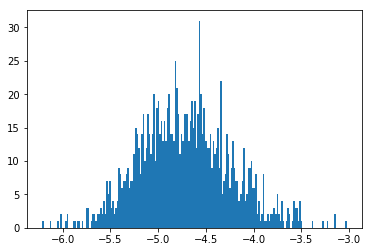

In [151]:
plt.hist(np.log(stock_returns[0]),bins=200)
plt.show()

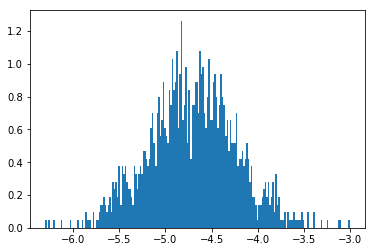

In [152]:
mu = np.mean(np.log(stock_returns[0]))
sigma = np.std(np.log(stock_returns[0]))

s = np.random.normal(mu, sigma, 1300)
plt.hist(s, bins=200, normed=True)
plt.show()

In [153]:
# heavy tail distribution of returns : we take log(returns) instead of returns

In [154]:
log_returns = True

In [155]:
# ML for only one stock

In [156]:
index_stock = random.randint(0,len(stock_returns)-1)
returns = stock_returns[index_stock]

if log_returns:
    temp = np.empty(len(np.where(returns!=0)[0]))
    for i in range(len(np.where(returns!=0)[0])):
        temp[i] = returns[np.where(returns!=0)[0][i]]
    returns = np.log(temp)


In [157]:
# depth of learning

In [158]:
depth = 5

In [159]:
X_ = []
y_ = []

for i in range(len(returns)-depth):
    temp = returns
    y_.append(temp[i])
    X_.append(np.array(temp[i+1:i+1+depth]))
y_ = np.array(y_)

In [160]:
# transform X_ to the required shape for ML algo

In [161]:
temp = np.empty((len(X_)-1,len(X_[0])))
for i in range(len(temp)):
    temp[i] = np.array(X_[i])
X_ = temp
y_ = y_[:len(X_)]

In [162]:
# focus only on recent data

In [163]:
n_data_for_training = 500
start_index = 50
X_, X_all = X_[start_index:start_index+n_data_for_training], X_
y_, y_all = y_[start_index:start_index+n_data_for_training], y_

In [164]:
def cross_validate(design_matrix, labels, regressor, cv_folds):

    pred = np.zeros(labels.shape) # Hold all predictions, in correct order.
    for tr, te in cv_folds:        
        scaler = preprocessing.StandardScaler()
        Xtr = scaler.fit_transform(design_matrix[tr,:])
        ytr = labels[tr]
        Xte = scaler.transform(design_matrix[te,:])
        regressor.fit(Xtr, ytr)
        pred[te] = (regressor.predict(Xte))
        
    return pred

In [165]:
# Set up a stratified 10-fold cross-validation
skf = model_selection.KFold(n_splits=10)
skf.get_n_splits(X_, y_)
folds = [(tr,te) for (tr,te) in skf.split(X_, y_)]

In [166]:
# random forest

In [167]:
optimize_rf = True

In [168]:
if optimize_rf:
    param_grid = {'n_estimators':[1,10],
            'max_features':[1,4],
            'max_depth':[1,9]}

    clf_rf = GridSearchCV(RandomForestRegressor(),
                   param_grid)

    ypred_randomforest = cross_validate(X_, y_, clf_rf, folds)
    
else:
    ypred_randomforest = cross_validate(X_,y_,RandomForestRegressor(),folds)

In [169]:
# svm

In [170]:
optimize_svm = True

In [171]:
if optimize_svm:
    param_grid = {'C':[0.01,10]}

    clf_svm = GridSearchCV(svm.SVR(kernel='linear'),
                   param_grid)

    ypred_svm = cross_validate(X_, y_, clf_svm, folds)

else:
    ypred_svm = cross_validate(X_, y_, svm.SVR(kernel='linear'), folds)

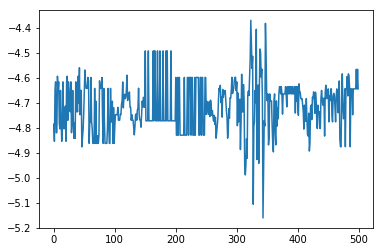

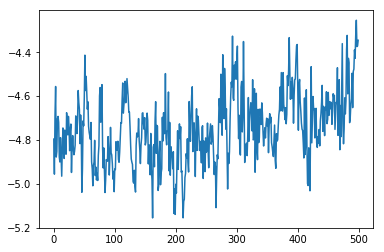

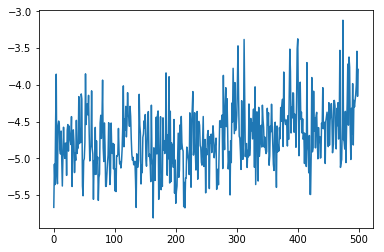

In [172]:
plt.plot(ypred_randomforest)
plt.show()
plt.plot(ypred_svm)
plt.show()
plt.plot(y_)
plt.show()

In [173]:
# comparaison avec différents prédicteurs "stupides"
y1_ = np.array([np.mean(y_)]*len(y_))

print("mean of |y1_ - y_|   :   "+str(np.mean(np.abs(y1_-y_))))
print("explained variance : "+str(metrics.explained_variance_score(y_,y1_)))
print("mean absolute error : "+str(metrics.mean_absolute_error(y_,y1_)))
print("mean squared error : "+str(metrics.mean_squared_error(y_,y1_)))
print("r2 score : "+str(metrics.r2_score(y_,y1_)))

mean of |y1_ - y_|   :   0.33553845463768467
explained variance : 1.1102230246251565e-16
mean absolute error : 0.33553845463768467
mean squared error : 0.1812427015841532
r2 score : 0.0


In [174]:
# comparaison avec différents prédicteurs "stupides"
y1_ = np.array([np.mean(y_)]*len(y_))

print("mean of |y1_ - y_|   :   "+str(np.mean(np.abs(y1_-y_))))
print("explained variance : "+str(metrics.explained_variance_score(y_,y1_)))
print("mean absolute error : "+str(metrics.mean_absolute_error(y_,y1_)))
print("mean squared error : "+str(metrics.mean_squared_error(y_,y1_)))
print("r2 score : "+str(metrics.r2_score(y_,y1_)))

mean of |y1_ - y_|   :   0.33553845463768467
explained variance : 1.1102230246251565e-16
mean absolute error : 0.33553845463768467
mean squared error : 0.1812427015841532
r2 score : 0.0


In [175]:
# random forest
print("mean of |ypred_randomforest - y_|   :   "+str(np.mean(np.abs(ypred_randomforest-y_))))
print("explained variance : "+str(metrics.explained_variance_score(y_,ypred_randomforest)))
print("mean absolute error : "+str(metrics.mean_absolute_error(y_,ypred_randomforest)))
print("mean squared error : "+str(metrics.mean_squared_error(y_,ypred_randomforest)))
print("r2 score : "+str(metrics.r2_score(y_,ypred_randomforest)))

mean of |ypred_randomforest - y_|   :   0.3283255543902947
explained variance : 0.020705811834802246
mean absolute error : 0.3283255543902947
mean squared error : 0.17753041485405366
r2 score : 0.020482406726738622


In [176]:
# random forest
print("mean of |ypred_randomforest - y_|   :   "+str(np.mean(np.abs(ypred_randomforest-y_))))
print("explained variance : "+str(metrics.explained_variance_score(y_,ypred_randomforest)))
print("mean absolute error : "+str(metrics.mean_absolute_error(y_,ypred_randomforest)))
print("mean squared error : "+str(metrics.mean_squared_error(y_,ypred_randomforest)))
print("r2 score : "+str(metrics.r2_score(y_,ypred_randomforest)))

mean of |ypred_randomforest - y_|   :   0.3283255543902947
explained variance : 0.020705811834802246
mean absolute error : 0.3283255543902947
mean squared error : 0.17753041485405366
r2 score : 0.020482406726738622


In [177]:
# svm
print("mean of |ypred_svm - y_|   :   "+str(np.mean(np.abs(ypred_svm-y_))))
print("explained variance : "+str(metrics.explained_variance_score(y_,ypred_svm)))
print("mean absolute error : "+str(metrics.mean_absolute_error(y_,ypred_svm)))
print("mean squared error : "+str(metrics.mean_squared_error(y_,ypred_svm)))
print("r2 score : "+str(metrics.r2_score(y_,ypred_svm)))

mean of |ypred_svm - y_|   :   0.30993395697176374
explained variance : 0.13172536597886864
mean absolute error : 0.30993395697176374
mean squared error : 0.1580590352558838
r2 score : 0.1279150339607189


In [178]:
# svm
print("mean of |ypred_svm - y_|   :   "+str(np.mean(np.abs(ypred_svm-y_))))
print("explained variance : "+str(metrics.explained_variance_score(y_,ypred_svm)))
print("mean absolute error : "+str(metrics.mean_absolute_error(y_,ypred_svm)))
print("mean squared error : "+str(metrics.mean_squared_error(y_,ypred_svm)))
print("r2 score : "+str(metrics.r2_score(y_,ypred_svm)))

mean of |ypred_svm - y_|   :   0.30993395697176374
explained variance : 0.13172536597886864
mean absolute error : 0.30993395697176374
mean squared error : 0.1580590352558838
r2 score : 0.1279150339607189
